In [22]:
# Import libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

In [23]:
# Load data
df = pd.read_csv('SMDG_results.csv')

# Remove rows with missing values
df = df.dropna()

# Remove rows where glaucoma is not 0 or 1
# df = df[df['glaucoma'].isin([0, 1])]

# Remove unnecesary columns
keep = ['filename', 'glaucoma'] + [col for col in df.columns if 'pcdr_' in col]
df = df[keep]

# Keep only rows with filename starting with 'ORIGA'
df = df[df['filename'].str.startswith('ORIGA')]

# Cap pcdr_ values to 1
df[df.iloc[:, 2:] > 1] = 1

# Keep only rows that have pcdr_ values (lb, ub]
lb = 0 ; ub = 1
df = df[(df.iloc[:, 2:] <= lb).any(axis=1).__invert__() & (df.iloc[:, 2:] > ub).any(axis=1).__invert__()]

# Remove rows with all pcdr_ values equal to 1
df = df[(df.iloc[:, 2:] == 1).all(axis=1).__invert__()]

# Split data into train and test
seed = np.random.randint(0, 10000)
np.random.seed(seed)
train = df.sample(frac=0.7)
test = df.drop(train.index)
print('Train:', train.shape[0])
print('Test:', test.shape[0])
print('#############################################')
print('Images suitable for analysis:', df.shape[0])
print('Glaucoma:', (df['glaucoma'] == 1).sum())
print('Non glaucoma:', (df['glaucoma'] == 0).sum())
print('Glaucoma-suspect:', (df['glaucoma'] == -1).sum())

Train: 421
Test: 181
#############################################
Images suitable for analysis: 602
Glaucoma: 141
Non glaucoma: 461
Glaucoma-suspect: 0


**Disclaimer**

- Disc, cup and fovea segmentations are done using segmentation CNNs. Very useful for large batches of data but can generate some weird segmentations, especially in low quality fundus images.

**Excluding rules**

- All pCDR values == 1: ellipses fitted to cup and disc segmentations are equal or almost equal.
  
- pCDR values very low: generally caused by the disc segmentation not being great (disc surrounding tissue, pathology near disc, disc edge barely visible...).
  
- pCDR values > 1: disc and cup ellipses are very very close together and, mathematically, the calculation of the intersection points leads to the cup_points going over the disc_points.

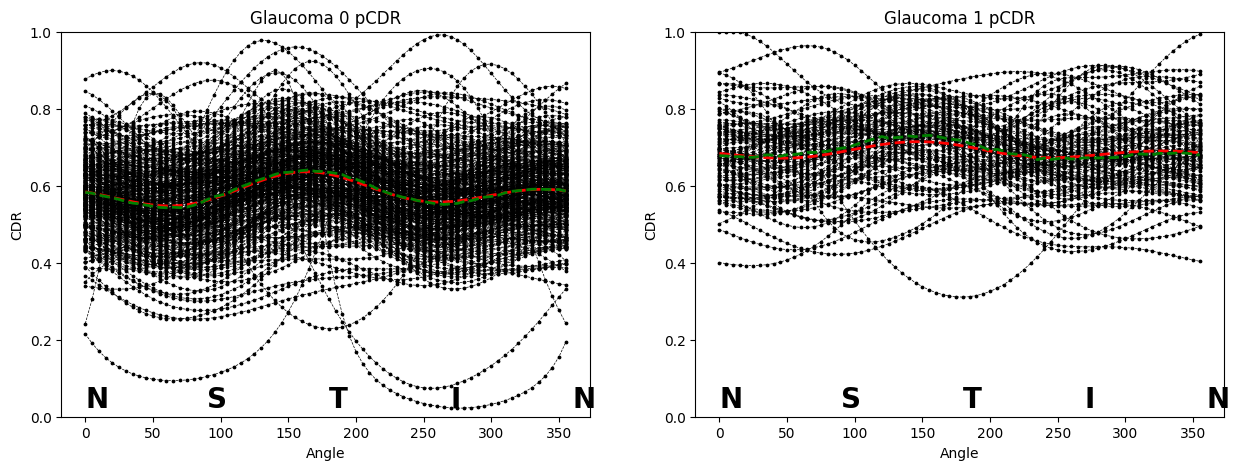

In [24]:
# Group by glaucoma status
df_grouped = train.groupby('glaucoma')

# Plot pcdr values
plt.figure(figsize=(15, 5))
# Number of groups to plot
n_groups = len(df_grouped)
for i, (name, group) in enumerate(df_grouped):
    plt.subplot(1, n_groups, i + 1)
    group = group.drop(['filename', 'glaucoma'], axis=1)
    cdr = group.values.T
    angles = [int(col.split('_')[1]) for col in group.columns if col.startswith('pcdr_')]
    angles = np.tile(angles, (cdr.shape[1], 1)).T # Make angles same shape as cdr for plotting
    plt.plot(angles, cdr, 'k--', linewidth=0.5)
    plt.scatter(angles, cdr, s=3, c='k')
    
    # Plot mean and median
    mean_cdr = np.mean(cdr, axis=1)
    median_cdr = np.median(cdr, axis=1)
    plt.plot(angles[:, 0], mean_cdr, 'r--', linewidth=2)
    plt.plot(angles[:, 0], median_cdr, 'g--', linewidth=2)
    
    # Overlay N S T I N labels on top of the X axis
    angle = [0, 90, 180, 270, 360]
    quadrant = ['N', 'S', 'T', 'I', 'N']
    for a, q in zip(angle, quadrant):
        plt.text(a, 0.025, q, fontsize=20, color='k', fontweight='bold')
    
    plt.title(f'Glaucoma {name} pCDR')
    plt.xlabel('Angle')
    plt.ylabel('CDR')
    plt.ylim(0, 1)
    
plt.show()

In [25]:
# Define method to calculate Mahalanobis distance
def mahalanobis(x, mu, cov):
    """
    Calculate Mahalanobis distance between two vectors x and mu using covariance matrix cov.
    
    Parameters
    ----------
    x : (N,M) array_like
        Input array.
    mu : (N,) array_like
        Mean vector of the distribution.
    cov : (N,N) array_like
        Covariance matrix of the distribution.
        
    """
    
    inv_cov = np.linalg.inv(cov)
    delta = x - mu
    m = np.dot(np.dot(delta, inv_cov), delta.T)
    out = np.sqrt(m)
    return out

# Calculate Mahalanobis distance for each group
cov_matrices = {}
mean_vectors = {}
for name, group in df_grouped:
    # Covariance matrix
    cov = np.cov(group.iloc[:, 2:].values.T)
    # Add covariance matrix to dictionary
    cov_matrices.update({name: cov})
    # Add mean vector to dictionary
    mean_vectors.update({name: np.mean(group.iloc[:, 2:].values, axis=0)})

Prior probability of glaucoma: 0.22327790973871733
#############################################
Log prior odds: -1.2466653886272496
Posterior odds information
count     1.430000e+02
mean      1.633512e-01
std       3.596277e-01
min      5.137531e-256
25%       2.074937e-03
50%       4.320391e-02
75%       1.634661e-01
max       2.941416e+00
Name: log_posterior_odds, dtype: float64


/tmp/ipykernel_681065/2814650398.py:20: RuntimeWarning: invalid value encountered in sqrt
  out = np.sqrt(m)
/tmp/ipykernel_681065/2814650398.py:20: RuntimeWarning: invalid value encountered in sqrt
  out = np.sqrt(m)


Text(0.5, 1.0, 'Posterior probability of patients (test set)')

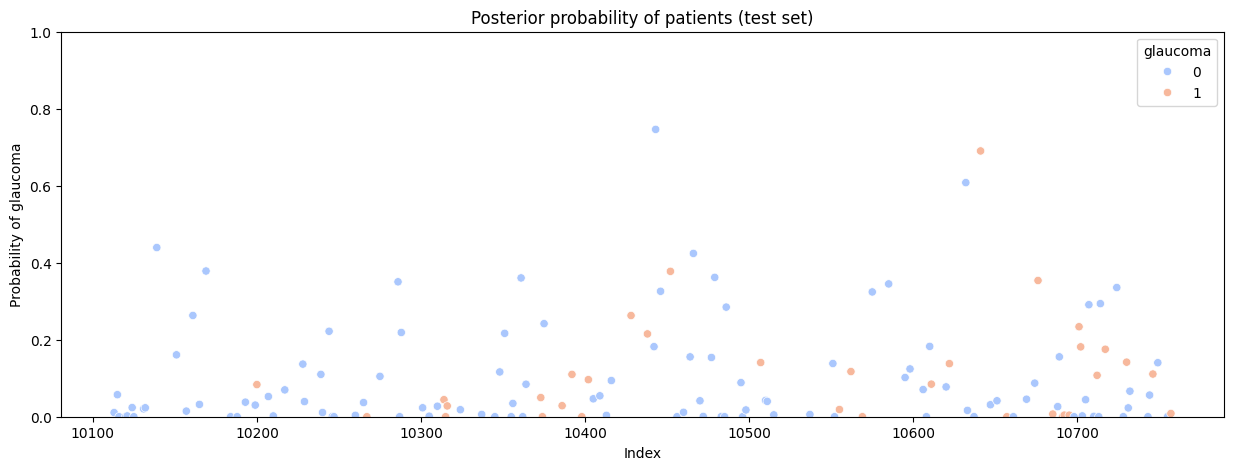

In [26]:
# Calculate Mahalanobis distance on test for each group
test2 = pd.DataFrame(index=test.index)
for k, v in cov_matrices.items():
    mu = mean_vectors.get(k)
    x = test.iloc[:, 2:].values
    mahal = mahalanobis(x=x, mu=mu, cov=v)
    # Add Mahalanobis distance to test2
    col_name = f'mahalanobis_{k}'
    test2[col_name] = mahal.diagonal()
    
# Prior probability of glaucoma
prior_glaucoma = (train['glaucoma'] == 1).sum() / train.shape[0] # ((train['glaucoma'] == 1).sum() + (train['glaucoma'] == 0).sum())
print('Prior probability of glaucoma:', prior_glaucoma)
print('#############################################')

# log(posterior odds) = log(prior odds) + 0.5 * (mahalanobis_0 - mahalanobis_1)
DDI = test2['mahalanobis_0'] - test2['mahalanobis_1']
log_prior_odds = np.log(prior_glaucoma / (1 - prior_glaucoma))
test2['log_posterior_odds'] = log_prior_odds + 0.5 * DDI
# Print DDI distribution information
print(f'Log prior odds: {log_prior_odds}')
# Posterior odds information
print('Posterior odds information')
print(np.exp(test2['log_posterior_odds']).describe())

# Posterior probability of glaucoma
test2['posterior_probability'] = 1 / (1 + np.exp(-test2['log_posterior_odds']))

# Scatter plot of posterior probability of suspected glaucoma
plt.figure(figsize=(15, 5))
sns.scatterplot(x=test2.index, y=test2['posterior_probability'], hue=test['glaucoma'], palette='coolwarm')
plt.ylim(0, 1)
plt.xlabel('Index')
plt.ylabel('Probability of glaucoma')
plt.title('Posterior probability of patients (test set)')

In [27]:
# Create a dataframe with column names ['filename', 'glaucoma', 'angle', 'pcdr']
train_mdl = pd.DataFrame(columns=['filename', 'glaucoma', 'angle', 'pcdr'])

# Initialize a list to collect new rows
new_rows = []

for i, row in train.iterrows():
    # Get filename and glaucoma status
    filename = row['filename']
    glaucoma = row['glaucoma']
    # Iterate over each angle
    for id, col in enumerate(train.columns[2:]):
        angle = int(col.split('_')[1])
        pcdr = row[col]
        # Add data to the list of new rows
        new_rows.append({'filename': filename, 'glaucoma': glaucoma, 'angle': angle, 
                         'd':angle/5 + 1, 'd_id': id, 
                         'pcdr': pcdr}) 

# Create a new DataFrame from the list of new rows
train_mdl = pd.DataFrame(new_rows)
        
train_mdl

,filename,glaucoma,angle,d,d_id,pcdr
0,ORIGA-36.png,1,0,1.0,0,0.486280
1,ORIGA-36.png,1,5,2.0,1,0.479130
2,ORIGA-36.png,1,10,3.0,2,0.472112
3,ORIGA-36.png,1,15,4.0,3,0.465328
4,ORIGA-36.png,1,20,5.0,4,0.458889
...,...,...,...,...,...,...
30307,ORIGA-588.png,1,335,68.0,67,0.674086
30308,ORIGA-588.png,1,340,69.0,68,0.672438
30309,ORIGA-588.png,1,345,70.0,69,0.670792
30310,ORIGA-588.png,1,350,71.0,70,0.669272


In [28]:
formula = 'pcdr ~ 1 + np.sin(2*np.pi*d/72) + np.cos(2*np.pi*d/72) + np.sin(4*np.pi*d/72) + np.cos(4*np.pi*d/72)'

# Mixed LM model
model = smf.mixedlm(formula, train_mdl, groups=train_mdl['glaucoma'],
                    re_formula='1', vc_formula={'glaucoma:d_id': '0 + C(d_id)'})

# Fit the model
result = model.fit()

# Print the summary
print(result.summary())

endog:            pcdr
0      0.486280
1      0.479130
2      0.472112
3      0.465328
4      0.458889
...         ...
30307  0.674086
30308  0.672438
30309  0.670792
30310  0.669272
30311  0.668010

[30312 rows x 1 columns]
exog:        Intercept  np.sin(2 * np.pi * d / 72)  np.cos(2 * np.pi * d / 72)  \
0            1.0                8.715574e-02                    0.996195   
1            1.0                1.736482e-01                    0.984808   
2            1.0                2.588190e-01                    0.965926   
3            1.0                3.420201e-01                    0.939693   
4            1.0                4.226183e-01                    0.906308   
...          ...                         ...                         ...   
30307        1.0               -3.420201e-01                    0.939693   
30308        1.0               -2.588190e-01                    0.965926   
30309        1.0               -1.736482e-01                    0.984808   
30310    

/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/base/model.py:609: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/base/model.py:609: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200

                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     pcdr      
No. Observations:       30312       Method:                 REML      
No. Groups:             2           Scale:                  0.0099    
Min. group size:        6768        Log-Likelihood:         26947.8312
Max. group size:        23544       Converged:              No        
Mean group size:        15156.0                                       
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.636    0.070   9.079 0.000  0.499  0.773
np.sin(2 * np.pi * d / 72)  0.001    0.001   1.700 0.089 -0.000  0.003
np.cos(2 * np.pi * d / 72) -0.020    0.001 -31.701 0.000 -0.021 -0.019
np.sin(4 * np.pi * d / 72) -0.013    0.001 -16.539 0.000 -0.015 -0.012
np.cos(4 * np.pi * d / 

/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/base/model.py:609: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 78.593438
  warnings.warn(msg, ConvergenceWarning)
/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [29]:
# Calculate the overall mean CDR-profile for each group
mu_cdr_0 = train[train['glaucoma'] == 0].iloc[:, 2:].values.mean()
mu_cdr_1 = train[train['glaucoma'] == 1].iloc[:, 2:].values.mean()

# Insert mean CDR-profile into train
train.loc[train['glaucoma'] == 0, 'mean_cdr'] = mu_cdr_0
train.loc[train['glaucoma'] == 1, 'mean_cdr'] = mu_cdr_1

# Insert a unique identifier for each filename
train['id'] = train['filename'].str.extract('(\d+)').astype(int)

# Melt the dataframe to long format
angles = list(range(0, 361))
value_vars = [f'pcdr_{angle}' for angle in angles if f'pcdr_{angle}' in train.columns]
train_long = pd.melt(train, id_vars=['filename', 'id', 'glaucoma', 'mean_cdr'], value_vars=value_vars, 
                     var_name='angle', value_name='pcdr_value')

# Extract the angle from the column name
train_long['angle'] = train_long['angle'].str.extract('(\d+)').astype(int)

# Precompute sine and cosine values
sin1_values = {d: np.sin(2 * np.pi * d / 72) for d in range(0, 361, 5)}
cos1_values = {d: np.cos(2 * np.pi * d / 72) for d in range(0, 361, 5)}
sin2_values = {d: np.sin(2 * np.pi * d / 36) for d in range(0, 361, 5)}
cos2_values = {d: np.cos(2 * np.pi * d / 36) for d in range(0, 361, 5)}

# Create a dictionary to store new columns
new_columns = {}
for d in range(0, 361, 5):
    new_columns[f'pcdr_{d}_sin1'] = sin1_values[d]
    new_columns[f'pcdr_{d}_cos1'] = cos1_values[d]
    new_columns[f'pcdr_{d}_sin2'] = sin2_values[d]
    new_columns[f'pcdr_{d}_cos2'] = cos2_values[d]

# Convert the dictionary to a DataFrame
new_columns_df = pd.DataFrame(new_columns, index=train_long.index)

# Concatenate the new columns to the original DataFrame
train_long = pd.concat([train_long, new_columns_df], axis=1)
train_long

,filename,id,glaucoma,mean_cdr,angle,pcdr_value,pcdr_0_sin1,pcdr_0_cos1,pcdr_0_sin2,pcdr_0_cos2,...,pcdr_350_sin2,pcdr_350_cos2,pcdr_355_sin1,pcdr_355_cos1,pcdr_355_sin2,pcdr_355_cos2,pcdr_360_sin1,pcdr_360_cos1,pcdr_360_sin2,pcdr_360_cos2
0,ORIGA-36.png,36,1,0.687846,0,0.486280,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
1,ORIGA-262.png,262,0,0.583677,0,0.433089,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
2,ORIGA-162.png,162,0,0.583677,0,0.738594,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
3,ORIGA-499.png,499,0,0.583677,0,0.557332,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
4,ORIGA-110.png,110,1,0.687846,0,0.654264,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30307,ORIGA-601.png,601,1,0.687846,355,0.704282,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
30308,ORIGA-106.png,106,0,0.583677,355,0.498358,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
30309,ORIGA-170.png,170,0,0.583677,355,0.627336,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0
30310,ORIGA-1.png,1,0,0.583677,355,0.724156,0.0,1.0,0.0,1.0,...,-0.984808,-0.173648,-0.422618,0.906308,-0.766044,0.642788,-1.224647e-15,1.0,-2.449294e-15,1.0


In [30]:
# Define the formula for the mixed effects model
# 'pcdr_value' is the dependent variable
# 'mean_cdr', 'angle', 'sin_angle', and 'cos_angle' are fixed effects
# '1|id' specifies random intercepts for each image
formula = 'pcdr_value ~ mean_cdr + angle + '
gonometric = [f'pcdr_{d}_sin1 + pcdr_{d}_cos1 + pcdr_{d}_sin2 + pcdr_{d}_cos2' for d in range(0, 361, 5)]
formula += ' + '.join(gonometric)
formula += ' + (1|id)'

# Fit the model
model = smf.mixedlm(formula, train_long, groups=train_long['filename'])
result = model.fit()

# Print the summary of the model
print(result.summary())

endog:        pcdr_value
0        0.486280
1        0.433089
2        0.738594
3        0.557332
4        0.654264
...           ...
30307    0.704282
30308    0.498358
30309    0.627336
30310    0.724156
30311    0.668010

[30312 rows x 1 columns]
exog:        Intercept  mean_cdr  angle  pcdr_0_sin1  pcdr_0_cos1  pcdr_0_sin2  \
0            1.0  0.687846    0.0          0.0          1.0          0.0   
1            1.0  0.583677    0.0          0.0          1.0          0.0   
2            1.0  0.583677    0.0          0.0          1.0          0.0   
3            1.0  0.583677    0.0          0.0          1.0          0.0   
4            1.0  0.687846    0.0          0.0          1.0          0.0   
...          ...       ...    ...          ...          ...          ...   
30307        1.0  0.687846  355.0          0.0          1.0          0.0   
30308        1.0  0.583677  355.0          0.0          1.0          0.0   
30309        1.0  0.583677  355.0          0.0          1.0  

LinAlgError: Singular matrix